# [1] 제출한 csv 파일을 다시 시각화해 점수가 감소된 원인 찾기

### 1. FISH_EYE image에서 초광각 이미지의 특성으로 생기는 필요없는 부분이 담김
### 차량의 뒷 범퍼를 construction으로 마스킹하게 되면서 점수감소가 예상됨

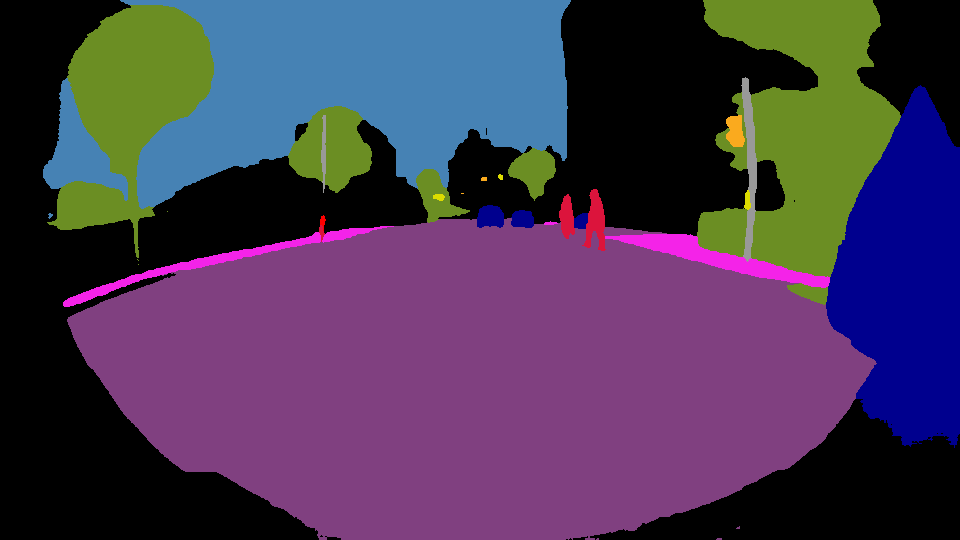

이미지 크기: (960, 540)
이미지 모드: RGB


In [8]:
from PIL import Image

# 이미지 파일 열기
image = Image.open("vit-adapter-896-4k-i66csv/TEST_0001.png")

display(image)

print(f"이미지 크기: {image.size}")
print(f"이미지 모드: {image.mode}")

## 2. 클래스별 색상
|   CLASSES     |       RGB Color         |
|:-------------:|:-----------------------:|
|     Road      |     [128, 64, 128]     |
|   Sidewalk    |     [244, 35, 232]     |
| Construction  |       [0, 0, 0]        |
|     Fence     |   [190, 153, 153]      |
|     Pole      |   [153, 153, 153]      |
| Traffic Light |   [250, 170, 30]       |
| Traffic Sign  |    [220, 220, 0]       |
|    Nature     |    [107, 142, 35]      |
|      Sky      |    [70, 130, 180]      |
|    Person     |    [220, 20, 60]       |
|     Rider     |      [255, 0, 0]       |
|      Car      |      [0, 0, 142]       |

## 3. 타겟 이미지에 적절한 필터(타원형)를 찾는 과정

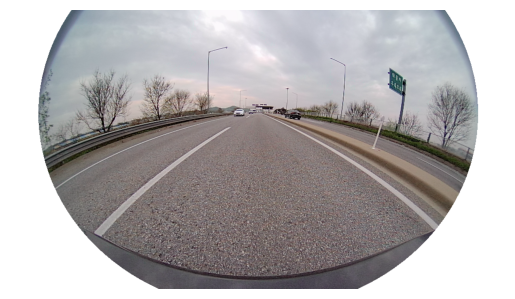

In [12]:
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

# 타겟 이미지
train_target_image = Image.open("C:/Users/ADMIN/Projects/JBK/mmseg_Data/open/train_target_image/TRAIN_TARGET_0001.png")
desired_size = (960, 540)
train_target_image = train_target_image.resize(desired_size, Image.NEAREST)
# 이미지 크기 및 배경색 설정
width, height = train_target_image.size
background_color = (255, 255, 255)  # 배경색을 흰색으로 설정

# 새로운 이미지 생성 (알파 채널 포함)
new_image = Image.new("RGBA", (width, height), background_color)
draw = ImageDraw.Draw(new_image)

# 타원 크기 및 위치 설정
ellipse_width = 850
ellipse_height = 900
ellipse_left = (width - ellipse_width) // 2
ellipse_top = (height - ellipse_height) // 2
ellipse_right = ellipse_left + ellipse_width
ellipse_bottom = ellipse_top + ellipse_height - 140

# 타원 그리기 (알파 채널 사용)
ellipse_color = (0, 0, 0, 0)  # 흰색 (RGB) 및 완전 불투명 (알파 채널)
draw.ellipse((ellipse_left, ellipse_top, ellipse_right, ellipse_bottom), fill=ellipse_color)

# 원본 이미지와 새로운 이미지 합치기
result_image = Image.alpha_composite(train_target_image.convert("RGBA"), new_image)

# 이미지를 matplotlib를 사용하여 표시
plt.imshow(result_image)
plt.axis('off')  # 축 숨기기
plt.show()


## 4. 필터가 추가된 inference code

In [ ]:
import os
import mmcv
import torch
from tqdm import tqdm
from mmseg.apis import init_segmentor, inference_segmentor, show_result_pyplot
from mmseg.models import build_segmentor
import pandas as pd
import numpy as np
import json
import numpy as np
import mmcv_custom   # noqa: F401,F403
import mmseg_custom 
import cv2
os.environ["CUDA_VISIBLE_DEVICES"]="0"
from PIL import Image, ImageDraw

def apply_ellipse_filter(input_image):
    # 이미지 크기 및 배경색 설정
    width, height = input_image.size
    background_color = (255, 255, 255)  # 배경색을 흰색으로 설정

    # 새로운 이미지 생성 (알파 채널 포함)
    new_image = Image.new("RGBA", (width, height), background_color)
    draw = ImageDraw.Draw(new_image)

    # 타원 크기 및 위치 설정
    ellipse_width = 850
    ellipse_height = 900
    ellipse_left = (width - ellipse_width) // 2
    ellipse_top = (height - ellipse_height) // 2
    ellipse_right = ellipse_left + ellipse_width
    ellipse_bottom = ellipse_top + ellipse_height - 140

    # 타원 그리기 (알파 채널 사용)
    ellipse_color = (0, 0, 0, 0)  # 흰색 (RGB) 및 완전 불투명 (알파 채널)
    draw.ellipse((ellipse_left, ellipse_top, ellipse_right, ellipse_bottom), fill=ellipse_color)

    # 입력 이미지와 새로운 이미지 합치기
    result_image = Image.alpha_composite(input_image.convert("RGBA"), new_image)

    return result_image

def rle_encode(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def main():
    #----------------------------------------------------------------------
    csv_save_dir = "work_dirs/infer"
    file_name = 'vit_896_16k_i67_filtered'
    img_output_folder = 'work_dirs/infer/vit_896_16k_i67_filter'
    config_file = 'work_dirs/vit-adapter-896/vit-adapter-896_for_infer.py'
    checkpoint_file = 'work_dirs/vit-adapter-896/best_mIoU_iter_16000.pth'
    #-----
    sample_path = "C:/Users/ADMIN/Projects/JBK/mmseg_Data/open/test.csv"
    test_image_path = "C:/Users/ADMIN/Projects/JBK/mmseg_Data/open/test_image"
    submit_path = "C:/Users/ADMIN/Projects/JBK/mmseg_Data/open/sample_submission.csv"
    #----------------------------------------------------------------------
    device = "cuda"
    
    model = init_segmentor(config_file, checkpoint_file, device)
    data = pd.read_csv(sample_path)['id'].values.tolist()

    with torch.no_grad():
        model.eval()
        result = []

        for img_id in tqdm(data):
            img_path = os.path.join(test_image_path, img_id + ".png")
            masks_list = inference_segmentor(model, img_path) #리스트로 된 마스크
            #이미지 저장 부분
            output_path = f'{img_output_folder}/infer_{img_id}_mask.png' 
            filtered_mask_output_path = f'{img_output_folder}/infer_{img_id}_mask_filtered.png' 
            os.makedirs(img_output_folder, exist_ok=True)
            img_result = model.show_result(img_path, masks_list, palette=None, show=False, opacity=0.7)

            mmcv.imwrite(img_result, output_path) 
                
            for mask in masks_list:
                mask = mask.astype(np.uint8)
                mask_img = Image.fromarray(mask)
                mask_img = mask_img.resize((960, 540), Image.NEAREST)
                mask_img = apply_ellipse_filter(mask_img) #필터 거치기
                mask_img.save(filtered_mask_output_path)
                mask = np.array(mask_img)
                
                for class_id in range(12):
                    class_mask = (mask == class_id).astype(np.uint8)
                    if np.sum(class_mask) > 0:  # If mask exists, encode
                        mask_rle = rle_encode(class_mask)
                        result.append(mask_rle)

                    else:  # If mask doesn't exist, append -1
                        result.append(-1)

    submit = pd.read_csv(submit_path)
    submit['mask_rle'] = result
    if not os.path.exists(csv_save_dir):
        os.makedirs(csv_save_dir)
    submit.to_csv(os.path.join(csv_save_dir, file_name + '.csv'), index=False)

main()

